=== training with full data ===


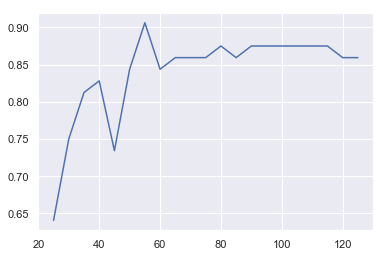

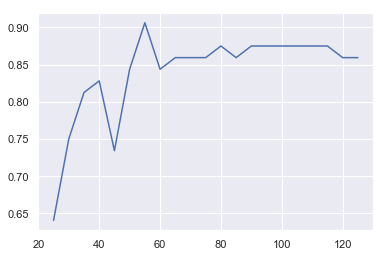

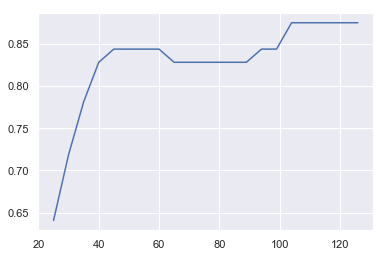



=== training with 2d PCA data for plotting ===
training accuracy: 0.7874015748031497
test accuracy: 0.765625


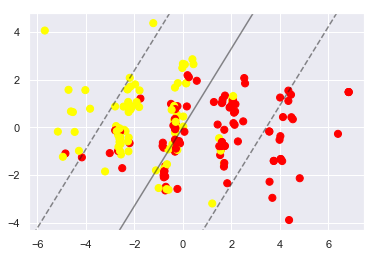

In [41]:
%matplotlib inline
import json
from pprint import pprint
import copy

import numpy as np
from scipy import stats
from sklearn.decomposition import PCA
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.calibration import CalibratedClassifierCV

# use seaborn plotting defaults
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

def get_feature(vis):
    """Given a vis json object, parse its feature """
    def parse_soft_rule(rule):
        head = rule[:rule.index("(")]
        body = rule[rule.index("(") + 1: rule.index(")")]
        literals = body.strip().split(",")
        return head, literals
    facts = [x for x in json.loads(vis["draco"]) if x.startswith("soft")]
    feature = {}
    for r in facts:
        h, l = parse_soft_rule(r)
        rname = l[0] + "-" + l[1]
        if rname not in feature:
            feature[rname] = 0
        feature[rname] += 1
    return feature

def get_pair_feature(pair):
    """Get the feature of a pair that will be used in active learning"""
    if pair["comparator"] not in [">", "<"]:
        return None, None
    label = -1 if pair["comparator"] == "<" else 1
    left_facts = get_feature(pair["left"])
    right_facts = get_feature(pair["right"])
    combined = copy.copy(left_facts)
    for k, v in right_facts.items():
        if k not in combined:
            combined[k] = 0
        combined[k] -= v
    return combined, label

def plot_svc_decision_function(model, ax=None, plot_support=False):
    """Plot the decision function for a 2D SVC"""
    if ax is None:
        ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # create grid to evaluate model
    x = np.linspace(xlim[0], xlim[1], 30)
    y = np.linspace(ylim[0], ylim[1], 30)
    Y, X = np.meshgrid(y, x)
    xy = np.vstack([X.ravel(), Y.ravel()]).T
    P = model.decision_function(xy).reshape(X.shape)
    
    # plot decision boundary and margins
    ax.contour(X, Y, P, colors='k',
               levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])
    
    # plot support vectors
    if plot_support:
        ax.scatter(model.support_vectors_[:, 0],
                   model.support_vectors_[:, 1],
                   s=300, linewidth=1, facecolors='none');
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

    
def train_and_eval(model, X, y, test_split=0.33):
    """train and eval the model using data X, y"""
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_split, random_state=42)    
    model.fit(X_train, y_train)
    
    print("training accuracy: {}".format(model.score(X_train, y_train)))
    print("test accuracy: {}".format(model.score(X_test, y_test)))

    
def active_learn(model, X, y, test_split=0.33, sample_func="entropy"):
    """active learning loop"""
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_split, random_state=42)    
    X_label, X_pool, y_label, y_pool = train_test_split(X_train, y_train, test_size=0.8, random_state=43)
    
    X_label, y_label = list(X_label), list(y_label)
    X_pool, y_pool = list(X_pool), list(y_pool)
    
    sample_size = 5
    
    train_size = []
    acc_list = []
    while len(X_pool) > 0:
        model.fit(X_label, y_label)
        
        acc = model.score(X_test, y_test)
        acc_list.append(acc)
        train_size.append(len(X_label))
        
        # different sample function to obtain new data
        if sample_func == "entropy":
            # entropy based sampling
            prob_vals = model.predict_proba(X_pool)
            entropy_uncertainty = (-prob_vals * np.log2(prob_vals)).sum(axis=1)
            selections = (np.argsort(entropy_uncertainty)[::-1])[:sample_size]
        elif sample_func == "margin":
            # entropy based sampling
            prob_vals = model.predict_proba(X_pool)
            rev = np.sort(prob_vals, axis=1)[:, ::-1]
            values = rev[:, 0] - rev[:, 1]
            selections = np.argsort(values)[:sample_size]
        elif sample_func == "random":
            selections = np.random.choice(list(range(len(X_pool))), sample_size)

        X_label = X_label + [v for i,v in enumerate(X_pool) if i in selections]
        y_label = y_label + [v for i,v in enumerate(y_pool) if i in selections]
        
        X_pool = [v for i,v in enumerate(X_pool) if i not in selections]
        y_pool = [v for i,v in enumerate(y_pool) if i not in selections]
        
    plt.plot(train_size, acc_list)
    plt.show()
    #print(acc_list)
    
    
with open("pairs.json", "r") as f:
    pairs = json.load(f)
    data = []
    for p in pairs:
        feature, label = get_pair_feature(p)
        if feature is None:
            continue
        data.append((feature, label))
    all_features = list(set([k for p in data for k in p[0].keys()]))
    
    X = np.array([[(p[0][feature_name] if feature_name in p[0] else 0) 
                    for feature_name in all_features] for p in data])
    y = np.array([p[1] for p in data])
    
    print("=== training with full data ===")
    # training with the full data
    model = CalibratedClassifierCV(LinearSVC(fit_intercept=0), cv=5)
    #train_and_eval(model, X, y)
    active_learn(model, X, y, sample_func="entropy")
    active_learn(model, X, y, sample_func="margin")
    active_learn(model, X, y, sample_func="random")
    
    print("\n")
    print("=== training with 2d PCA data for plotting ===")
    
    # training with 2d data for plotting
    pca = PCA(n_components=2)
    pca.fit(X)
    X2d = pca.transform(X)
    model = LinearSVC(fit_intercept=0)
    train_and_eval(model, X2d, y)
    
    # plot ground truth labels and decision boundary
    plt.scatter(X2d[:, 0], X2d[:, 1], c=y, s=50, cmap='autumn');
    plot_svc_decision_function(model)